# Modeling

In [802]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pypfopt
#
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [803]:
df_static = pd.read_csv('../../data/df_overview.csv', index_col=0)
df_time_series = pd.read_csv('../../data/df_monthly_returns_complete.csv', index_col='Date')

### Define Source and Target

Columns:
1. Static fields:
    * Industry
    * Market capital
    * Trailing P/E ratio
    * Beta
    * Return on equity
2. Time series data:
    * Market returns

In [804]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1371
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1018
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,60.117208,1.037,...,0,0,0,0,0,0,0,0,0,1485
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,60.117208,0.957,...,0,0,0,0,0,0,0,0,0,1056
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,56.325686,0.594,...,0,0,1,0,0,0,0,0,0,1040
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1130
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,50.163413,1.191,...,0,0,0,0,0,0,0,0,0,1165
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [805]:
df_static_columns = []
# Industry
df_static_columns = [s for s in df_static.columns.to_list() if "industry_" in s]
# Stock ticker
#df_static_columns.append('stock_ticker_symbol')
df_static_columns.append('stock_ticker_label')
#
df_static_columns.append('company_esg_score')
#
df_static_columns.append('market_capital_scale')
df_static_columns.append('trailing_pe')
df_static_columns.append('beta')
df_static_columns.append('return_on_equity')

In [806]:
df_time_series = df_time_series.loc[:, ~df_time_series.columns.str.contains('^Unnamed')]

In [807]:
df_time_series = df_time_series.T
df_time_series

Date,1999-10-01,1999-11-01,1999-12-01,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,...,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01
RS1.L,NaN,1.13,1.11,1.02,1.00,1.00,1.00,1.00,1.00,1.01,...,1.11,0.96,0.96,0.96,1.01,0.95,1.00,1.19,0.96,0.99
KE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.09,0.88,0.95,0.96,0.97,1.10,0.96,1.08,0.78,0.95
TEG.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.05,0.99,0.86,1.12,1.06,1.06,0.96,1.02,1.06,1.10
LEG.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.13,0.98,0.88,1.17,1.00,1.02,0.97,1.06,1.08,1.08
SCS,NaN,1.03,0.92,0.96,1.08,0.98,0.99,1.04,1.39,1.01,...,1.10,0.94,1.09,0.95,0.92,1.14,0.95,1.12,0.98,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KVHI,NaN,0.99,1.01,1.22,1.97,1.03,0.69,0.99,1.16,0.95,...,1.10,0.93,0.98,1.07,0.94,1.08,0.90,0.96,1.00,1.00
MOON.L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.90,1.07,1.00,1.01,0.92,1.03,1.19,1.14,0.97,0.95
NEO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.89,0.92,1.05,1.01,0.89,0.98,1.01,1.28,0.93,0.95
6055.T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.97,1.01,1.01,0.95,0.94,0.86,1.14,0.90,0.89,0.94


In [808]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1371
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1018
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,60.117208,1.037,...,0,0,0,0,0,0,0,0,0,1485
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,60.117208,0.957,...,0,0,0,0,0,0,0,0,0,1056
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,56.325686,0.594,...,0,0,1,0,0,0,0,0,0,1040
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1130
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,50.163413,1.191,...,0,0,0,0,0,0,0,0,0,1165
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [809]:
df_static_sel = df_static[df_static_columns]
df_static_sel

,industry_Auto Components,industry_Automobiles,industry_Banks,industry_Building Products,industry_Chemicals,industry_Commercial Services,industry_Construction Materials,industry_Consumer Durables,industry_Consumer Services,industry_Containers & Packaging,...,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label,company_esg_score,market_capital_scale,trailing_pe,beta,return_on_equity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1371,4.5,0.000273,19.858974,0.863,0.132260
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1018,4.5,0.000024,21.370369,1.258,0.038540
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1485,4.6,0.000173,60.117208,1.037,-0.037660
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1056,5.1,0.000434,60.117208,0.957,-0.081260
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1400,5.3,0.000086,17.210526,1.314,0.106330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1040,20.0,0.000006,56.325686,0.594,-0.145360
1658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1130,20.0,0.000044,2035.000000,1.238,0.080959
1659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1165,20.0,0.000121,50.163413,1.191,-0.083910
1660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,141,20.0,0.010681,27.933996,0.585,0.135850


### Split the data into training and testing sets

In [810]:
# function to create train, test data given stock data and sequence length
def split_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index + look_back]) # Remove date columns

    data = np.array(data)

    test_set_size = int(np.round( 0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    X_train = data[: train_set_size]
    y_train = data[: train_set_size]

    X_test = data[train_set_size:]
    y_test = data[train_set_size:]

    return [torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.float32),
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32)]

# Combine both data types for each stock
# Assuming static data is repeated for each time step
def combine_data(time_series, static):
    combined = []
    for i in range(len(time_series)):
        combined.append(np.concatenate((time_series[i], static), axis=0))
    return np.array(combined)

In [811]:
df_static_sel.count().to_frame(name='Non-Null Count')

,Non-Null Count
industry_Auto Components,1653
industry_Automobiles,1653
industry_Banks,1653
industry_Building Products,1653
industry_Chemicals,1653
industry_Commercial Services,1653
industry_Construction Materials,1653
industry_Consumer Durables,1653
industry_Consumer Services,1653
industry_Containers & Packaging,1653


In [812]:
df_static_sel.columns

Index(['industry_Auto Components', 'industry_Automobiles', 'industry_Banks',
       'industry_Building Products', 'industry_Chemicals',
       'industry_Commercial Services', 'industry_Construction Materials',
       'industry_Consumer Durables', 'industry_Consumer Services',
       'industry_Containers & Packaging', 'industry_Diversified Financials',
       'industry_Diversified Metals', 'industry_Electrical Equipment',
       'industry_Energy Services', 'industry_Food Products',
       'industry_Food Retailers', 'industry_Healthcare',
       'industry_Homebuilders', 'industry_Household Products',
       'industry_Insurance', 'industry_Machinery', 'industry_Media',
       'industry_Oil & Gas Producers', 'industry_Paper & Forestry',
       'industry_Pharmaceuticals', 'industry_Precious Metals',
       'industry_Real Estate', 'industry_Refiners & Pipelines',
       'industry_Retailing', 'industry_Semiconductors',
       'industry_Software & Services', 'industry_Technology Hardware',
   

In [813]:
df_time_series_torch = torch.tensor(df_time_series.to_numpy(), dtype=torch.float32)
df_static_torch = torch.tensor(df_static_sel.to_numpy(), dtype=torch.float32) 

In [814]:
# @TODO resume here, split to train and test and use train when training and test part whe evaluating
# df_static_sel_train = df_static_sel[df_static_sel['st']]

In [815]:
len(df_static_torch[0])

44

In [820]:
#df_time_series_torch.shape
#df_time_series_torch = df_time_series_torch.unsqueeze(-1)
#df_time_series_torch = df_time_series_torch.permute(1, 0, 2)

In [822]:
df_time_series_torch.shape

torch.Size([300, 1653, 1])

In [817]:
class LSTMModel(nn.Module):
    def __init__(self, time_series_input, static_input, hidden_size=64, num_layers=2, output_size=1, learning_rate=0.001, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # data
        self.time_series_data = time_series_input
        self.static_data = static_input
        # LSTM for time-series data (stock returns)
        self.lstm = nn.LSTM(input_size=len(time_series_input),
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        # Fully connected layer for static data
        self.static_fc = nn.Linear(len(df_static_torch[0]), output_size) # input-size, output-size

        # Final output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, time_series_batch):
        # LSTM for time-series data (returns the last hidden state)
        lstm_out, _ = self.lstm(time_series_batch)
        # Process static data
        static_out = torch.relu(self.static_fc(self.static_data))
        # print(time_series_batch.shape)
        print(lstm_out.shape)
        print(static_out.shape)
        # Concatenate LSTM output and static data output
        combined = torch.cat((lstm_out, static_out), dim=1)

        # Final prediction
        output = self.fc(combined)

        return output


# Instantiate the model
model = LSTMModel(time_series_input=df_time_series_torch, # X_train,
                  static_input=df_static_torch,
                  learning_rate = 0.001,
                  output_size=1)
#
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(df_time_series_torch, df_time_series_torch), shuffle=True, batch_size=len(df_time_series_torch))


# Todo remove from here (duplicated for tests)
n_epochs = 1
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.T)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

<built-in method size of Tensor object at 0x2ae781bb0>
torch.Size([300, 1653])
torch.Size([300, 64])
torch.Size([1653, 1])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 300 but got size 1653 for tensor number 1 in the list.

### Training

In [495]:
# Move code here

### Evaluation

In [268]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_time_series) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[look_back: len(X_train)] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_time_series) * np.nan
    test_plot[len(X_train) + look_back: len(df_time_series)] = model(X_test)[:, -1, :]

torch.Size([240, 1653])


RuntimeError: input.size(-1) must be equal to input_size. Expected 240, got 1653

### Plotting

ValueError: x and y must be the same size

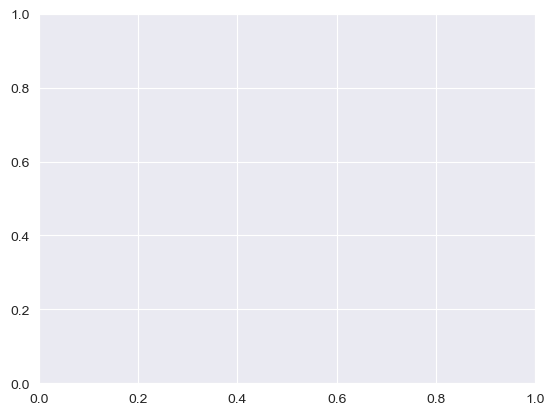

In [11]:
plt.scatter(X_train, y_train, color="blue", label="Actual")
plt.scatter(X_test, y_test, color="red", label="Predicted")
plt.title("DecisionTreeRegressor: Actual vs Predicted")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()